# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [2]:
from __future__ import print_function, division
%matplotlib inline

In [60]:
# Your code goes here
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [106]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [107]:
# Your code goes here
print("Number of instances: {}, number of attributes: {}".format(X.shape[0],X.shape[1]))
print("Shape of y: {}".format(y.shape))
print("Fisrt 10 data of y: {}".format(y[:10]))
X.head(3)

Number of instances: 2845, number of attributes: 1000
Shape of y: (2845,)
Fisrt 10 data of y: ['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.hockey'
 'comp.sys.ibm.pc.hardware' 'rec.sport.baseball' 'alt.atheism'
 'comp.sys.mac.hardware' 'rec.sport.hockey' 'alt.atheism'
 'rec.sport.baseball']


,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Your answer goes here*  
For X, we have 2845 data points, and there are 1000 words as features taht can be used to train the model.  
For y, it's the true labels(classes) for data points.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [108]:
# Your code goes here
kmeans = KMeans(n_clusters=5, random_state=1337)  
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1337, tol=0.0001,
    verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [109]:
# Your code goes here
X_mean = X.mean()
eucld_dist = 0.0
for i in range(1000):
    eucld_dist += np.linalg.norm(X.iloc[i] - X_mean)
mean_dist = eucld_dist / 1000
print("The mean of the euclidean distances: {}".format(mean_dist))
print("The inertia of the model: {}".format(kmeans.inertia_))
print("The adjusted rand index of the model: {}".format(adjusted_rand_score(y, kmeans.labels_)))

The mean of the euclidean distances: 0.949915748524
The inertia of the model: 2593.17430766
The adjusted rand index of the model: 0.216104350793


*Your answer goes here*  
1. Inertia: a measure of how internally coherent clusters.  
    Adjusted rand score: the similarity between two data clusterings.  
2. The adjusted rand index is 0.22, which is bigger than 0 but much smaller than 1, so that's acceptable. As to inertia, lower values are better and zero is optimal. But in very high-dimensional spaces like dimensions of this data is 1000, Euclidean distances tend to become inflated, and the result 2593 can be accepted.   
All in all, the clustering is acceptable as the dimension is very high.

### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [111]:
# Your code goes here
print("The number of datapoints with each label:")
for cat in cats:
    print("label {0} : {1}".format(cat,y[y==cat].size))

print("\nThe number of datapoints assigned to each cluster:")
for i in range(0,5):
    print("Cluster {0} : {1}".format(i, kmeans.labels_[kmeans.labels_ ==i].size))

The number of datapoints with each label:
label alt.atheism : 480
label comp.sys.ibm.pc.hardware : 590
label comp.sys.mac.hardware : 578
label rec.sport.baseball : 597
label rec.sport.hockey : 600

The number of datapoints assigned to each cluster:
Cluster 0 : 1050
Cluster 1 : 570
Cluster 2 : 649
Cluster 3 : 233
Cluster 4 : 343


*Your answer goes here*  
As we can see from the above result, the cluster divided 1050 data points into 'cluster centre 0', which is bad. The highest data points of each label is 600, nearly two classes were clustered into 'cluster centre 0'. This may be caused by the high relevance between classes like 'comp.sys.ibm.pc.hardware' and 'comp.sys.mac.hardware'.

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [112]:
# Your code goes here
distance = np.zeros((5,5))
for i in range(0,5):
    for j in range(0,5):
        distance[i][j] = np.linalg.norm(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j])
print("Distance Matrix: \n{}".format(distance))

Distance Matrix: 
[[ 0.          0.19481871  0.20336322  0.33095496  0.22738455]
 [ 0.19481871  0.          0.29223799  0.32040898  0.29210539]
 [ 0.20336322  0.29223799  0.          0.39748207  0.28369637]
 [ 0.33095496  0.32040898  0.39748207  0.          0.39922129]
 [ 0.22738455  0.29210539  0.28369637  0.39922129  0.        ]]


### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

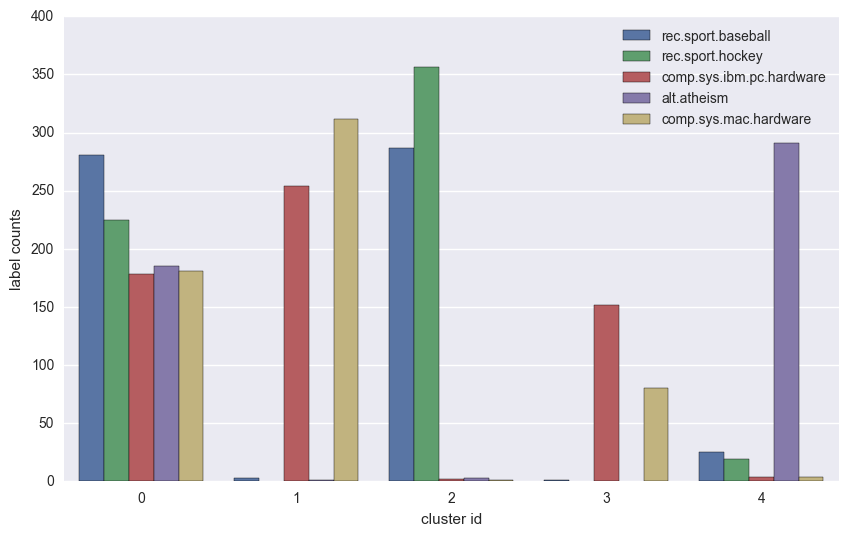

In [113]:
# Your code goes here
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.ylabel('label counts')
plt.show()

*Your answers goes here*  
There are multiple labels clustered into cluster centre 0, which is not good. However, as to cluster centre 4, the biggest couts is 'alt.atheism' will can be distinguished easily. And as to cluster centre 1 and 3, they can be grouped into 'comp.sys'. So, expect from centre 0, the cluster is not too bad, but this cluster is not good enough to imply on real applications.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [114]:
# Your code goes here
n_components = [1,2,3,5,10,20,50,100,500,1000] 
adjusted_rand_score_list = []
for d in n_components:
    pca = PCA(n_components=d)
    X_2d = pca.fit_transform(X)
    kmeans = KMeans(n_clusters=5, random_state=1337)  
    kmeans.fit(X_2d)
    adjusted_rand_score_list.append(adjusted_rand_score(y, kmeans.labels_))
    print("{0} The inertia:{1} adjusted_rand_score:{2}".format(d,kmeans.inertia_,adjusted_rand_score(y, kmeans.labels_)))

1 The inertia:2.82109066477 adjusted_rand_score:0.209466028491
2 The inertia:10.592280453 adjusted_rand_score:0.268079336483
3 The inertia:20.4235331658 adjusted_rand_score:0.239479218068
5 The inertia:49.8674692394 adjusted_rand_score:0.2288985833
10 The inertia:118.178301295 adjusted_rand_score:0.213854607491
20 The inertia:231.905790868 adjusted_rand_score:0.209500299493
50 The inertia:492.377897319 adjusted_rand_score:0.207798369276
100 The inertia:820.096306441 adjusted_rand_score:0.225048950168
500 The inertia:2145.62769513 adjusted_rand_score:0.205869464934
1000 The inertia:2593.17430766 adjusted_rand_score:0.216104350793


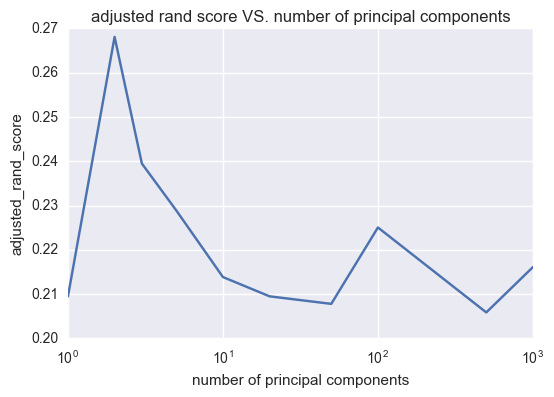

In [115]:
#log_n_components = map(lambda x:np.log(x),n_components)
plt.plot(n_components,adjusted_rand_score_list)
plt.xscale('log')
plt.title('adjusted rand score VS. number of principal components')
plt.ylabel('adjusted_rand_score')
plt.xlabel('number of principal components')
plt.show()

*Your answer goes here*  
1.  The adjusted rand score reachs low points at 50 and 500, and gets the highest point at 2.The graph shows the adjusted rand score against number of principal components, it means how the relevance between cluster centres according to the reduced dimensions, the samller adjusted rand score is, the better.
2. As mentioned in Quesion 1.3, the inertia is highly relevant to dimensions, the smaller the dimension is, the better inertia we will get, which is not meaningful.
3. Dimensionality reduction can reduce the noise of data, as not all the features have high weight in clustering. If we only foucus on principal components, the kmeans will be more precise without noise.

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

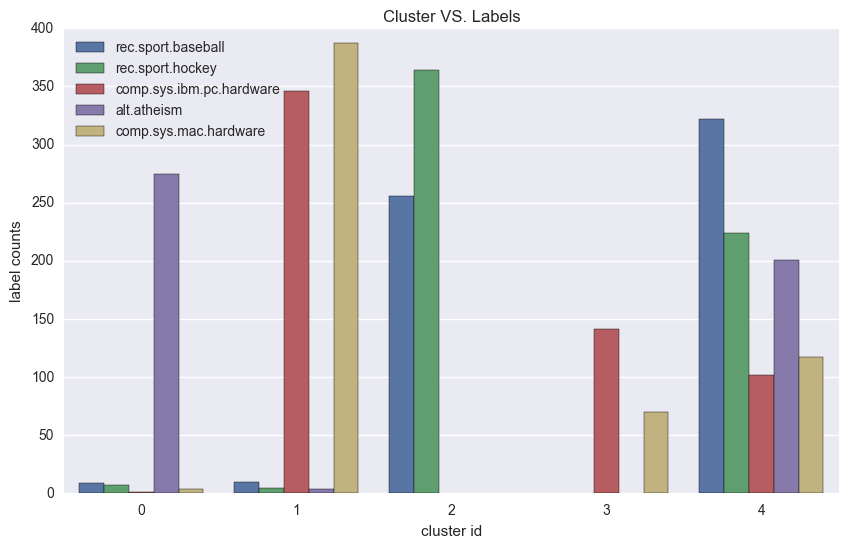


The number of datapoints assigned to each cluster:
Cluster 0 : 296
Cluster 1 : 752
Cluster 2 : 620
Cluster 3 : 211
Cluster 4 : 966


In [120]:
# Your code goes here  
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
kmeans_pca = KMeans(n_clusters=5, random_state=1337)  
kmeans_pca.fit(X_2d)

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.ylabel('label counts')
plt.title('Cluster VS. Labels')
plt.show()

print("\nThe number of datapoints assigned to each cluster:")
for i in range(0,5):
    print("Cluster {0} : {1}".format(i, kmeans_pca.labels_[kmeans_pca.labels_ ==i].size))

*Your answer goes here*  
This cluster classified 966 data points to cluster centre 4, which should be the same as cluster centre 4 of 1000 dimensions cluster. In this point, this cluster is better than the previous one. However, as to other cluster centres, the counts don't change a lot, which is similar to previous one. All in all, this cluster has improved a little.

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [127]:
# Your code goes here
interp_cats = ['alt.atheism',
               'comp.sys.mac.hardware',
               'rec.sport.hockey',
               'comp.sys.ibm.pc.hardware',
               'rec.sport.baseball']
labels_interp = np.array(interp_cats)[kmeans_pca.labels_ - 1]
print(kmeans_pca.labels_)
print(labels_interp)

[4 2 2 ..., 3 2 4]
['comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.sys.mac.hardware'
 ..., 'rec.sport.hockey' 'comp.sys.mac.hardware' 'comp.sys.ibm.pc.hardware']


### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

In [157]:
# Your code goes here
cm = confusion_matrix(y, labels_interp)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

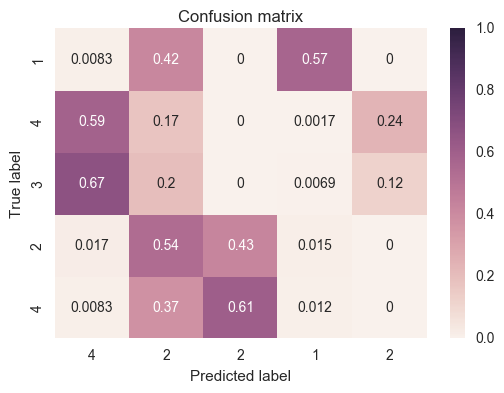

In [160]:
plt.figure()
plot_confusion_matrix(cm_norm, classes=kmeans_pca.labels_)

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

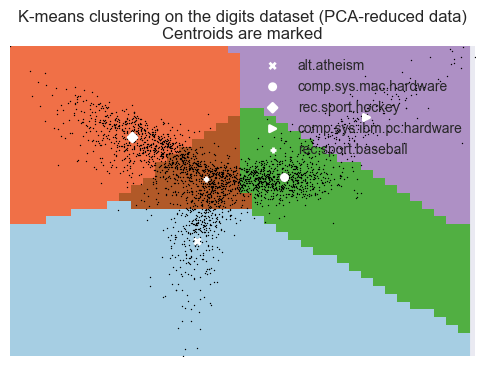

In [199]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans_pca_2 = KMeans(n_clusters=5, random_state=1337)
kmeans_pca_2.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca_2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans_pca_2.cluster_centers_

markers = ['x','o','D','>','+']
for i, inter_label in enumerate(interp_cats):
    plt.scatter(centroids[i][0], centroids[i][1],
                marker=markers[i], s=20, linewidths=2,
                color='w', zorder=10,label=inter_label)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.legend()
plt.show()

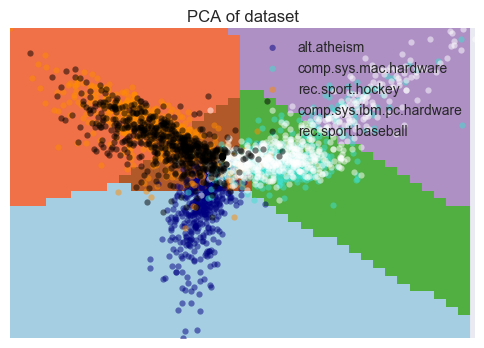

In [223]:
plt.figure(2)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

colors = ['navy', 'turquoise', 'darkorange','white','black']
target_names = interp_cats

for color, i, target_name in zip(colors, range(5), target_names):
    plt.scatter(reduced_data[y == interp_cats[i], 0], reduced_data[y == interp_cats[i], 1], color=color, alpha=0.5, lw=.01,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of dataset VS. True data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

*Your answer goes here*  
1. Yes, the samples are clustered by the distance between data points and cluster centres. As K-means will produce the same centres from a same given random_state value, so K-means is deterministic.
2. The default number of initialisations is 10, as I didn't set the n_init parameter, so Question 1.2 did multiple initialisations. The final results will be the best output of n_init consecutive runs in terms of inertia.
3. ‘random’: choose k observations (rows) at random from data for the initial centroids. The problem is that centres will depend on the rows that the initiliser chooses, and this will make kmeans algorithm non-deterministic.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [130]:
digits_data = pd.DataFrame(digits.data)
digits_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [131]:
# The max/min values for each dimension
for column in digits_data.columns:
    print('Dimension:{0} Max: {1} Min: {2}'.format(column,digits_data.max()[column],digits_data.min()[column]))

Dimension:0 Max: 0.0 Min: 0.0
Dimension:1 Max: 8.0 Min: 0.0
Dimension:2 Max: 16.0 Min: 0.0
Dimension:3 Max: 16.0 Min: 0.0
Dimension:4 Max: 16.0 Min: 0.0
Dimension:5 Max: 16.0 Min: 0.0
Dimension:6 Max: 16.0 Min: 0.0
Dimension:7 Max: 15.0 Min: 0.0
Dimension:8 Max: 2.0 Min: 0.0
Dimension:9 Max: 16.0 Min: 0.0
Dimension:10 Max: 16.0 Min: 0.0
Dimension:11 Max: 16.0 Min: 0.0
Dimension:12 Max: 16.0 Min: 0.0
Dimension:13 Max: 16.0 Min: 0.0
Dimension:14 Max: 16.0 Min: 0.0
Dimension:15 Max: 12.0 Min: 0.0
Dimension:16 Max: 2.0 Min: 0.0
Dimension:17 Max: 16.0 Min: 0.0
Dimension:18 Max: 16.0 Min: 0.0
Dimension:19 Max: 16.0 Min: 0.0
Dimension:20 Max: 16.0 Min: 0.0
Dimension:21 Max: 16.0 Min: 0.0
Dimension:22 Max: 16.0 Min: 0.0
Dimension:23 Max: 8.0 Min: 0.0
Dimension:24 Max: 1.0 Min: 0.0
Dimension:25 Max: 15.0 Min: 0.0
Dimension:26 Max: 16.0 Min: 0.0
Dimension:27 Max: 16.0 Min: 0.0
Dimension:28 Max: 16.0 Min: 0.0
Dimension:29 Max: 16.0 Min: 0.0
Dimension:30 Max: 15.0 Min: 0.0
Dimension:31 Max: 1.0 Mi

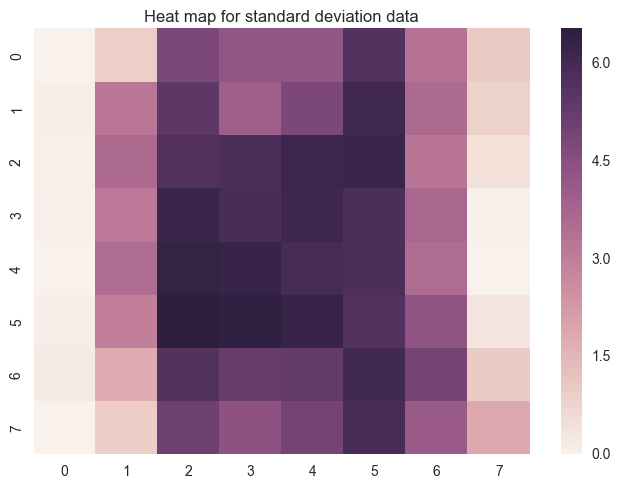

In [133]:
# Heat map for standard deviation data
std_digits = digits_data.std().reshape(8,8)
sns.heatmap(std_digits)
plt.title('Heat map for standard deviation data')
plt.show()

Heat map for standard deviation of each digit:


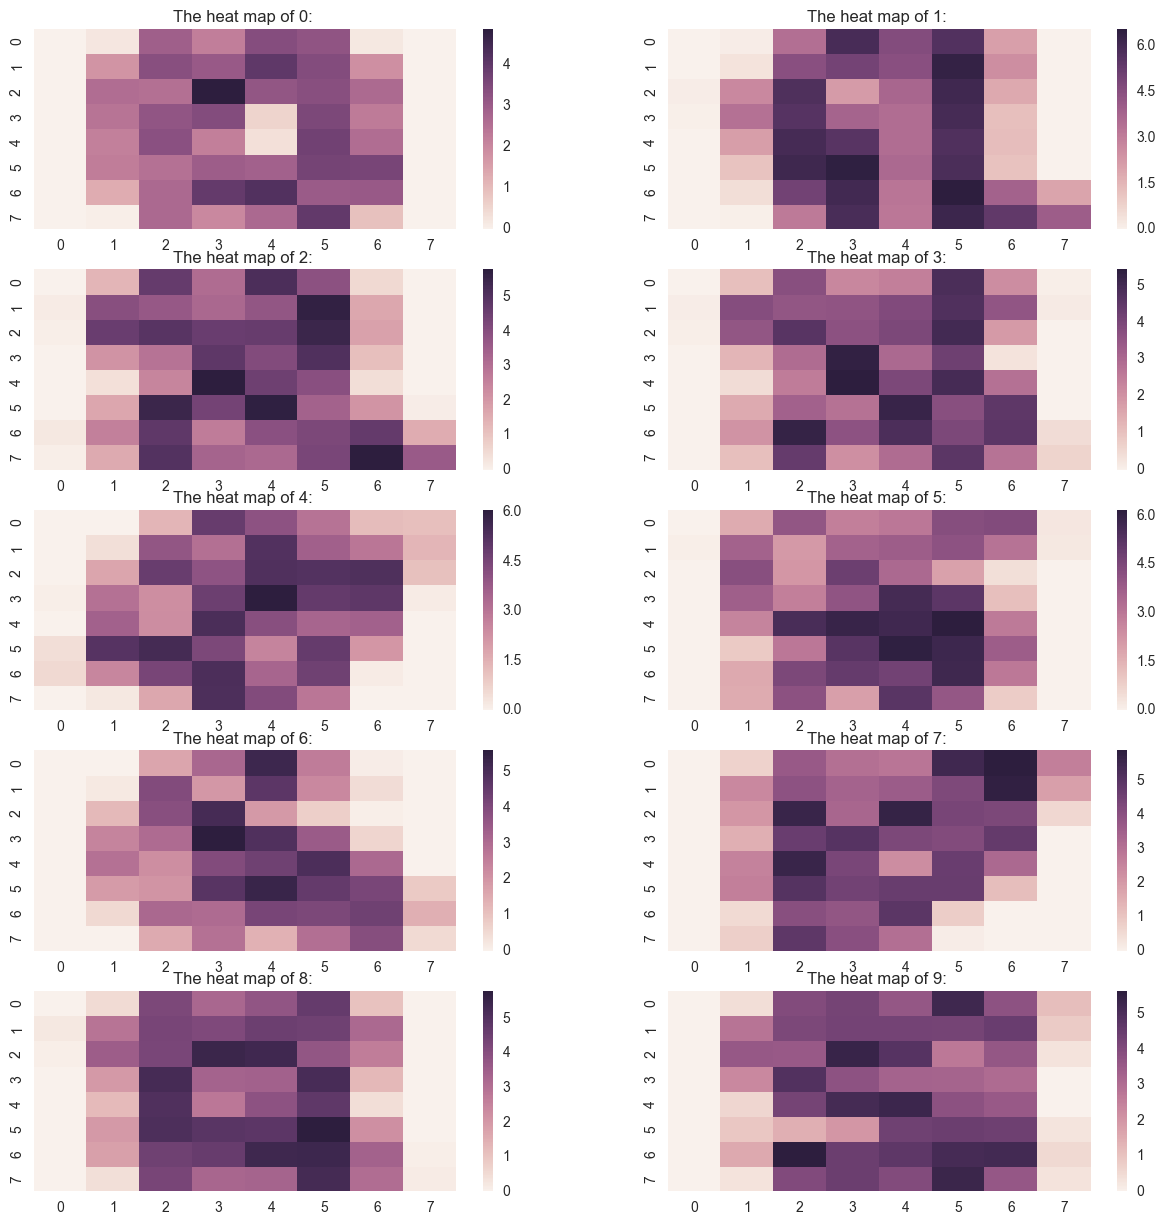

In [99]:
# Heat map for standard deviation of each digit
plt.figure()
plt.subplots(5,2,figsize = (15,15))
print('Heat map for standard deviation of each digit:')
for i in range(10):
    plt.subplot(5,2,i+1)
    std_digits_target = digits_data.groupby(target).std().loc[i].reshape(8,8)
    sns.heatmap(std_digits_target)
    plt.title('The heat map of {}: '.format(i))
plt.show()

The heat map of 0to9th data points: 


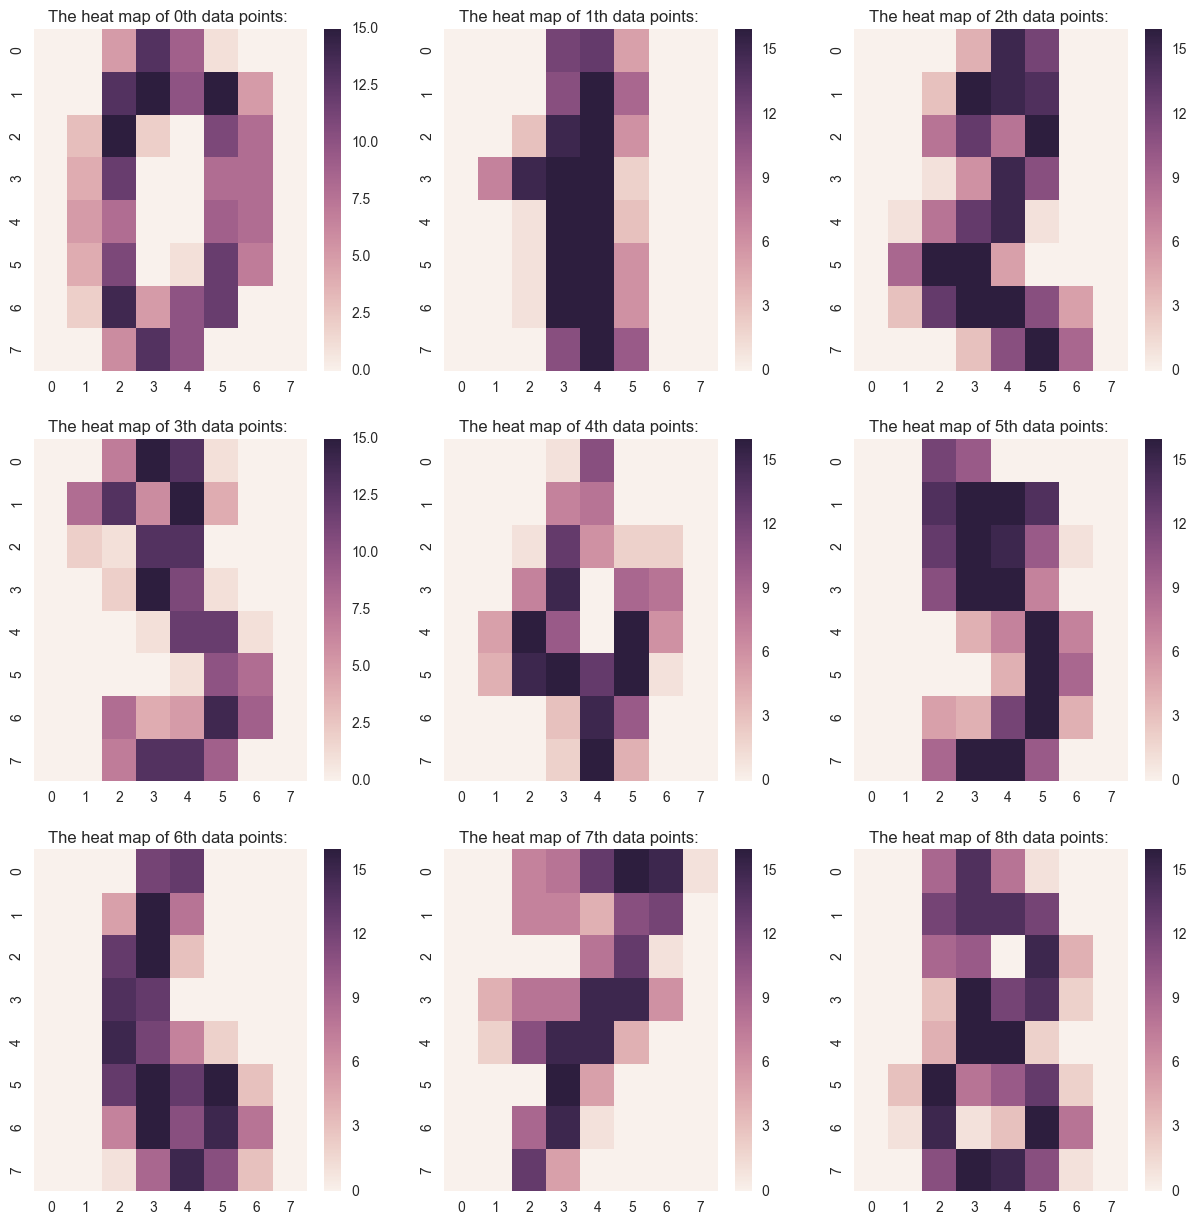

In [101]:
# The heat map of 0-9 data: 
print('The heat map of 0to9th data points: '.format(i))
plt.figure()
plt.subplots(3,3,figsize = (15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    std_digits_target = digits_data.head(9).loc[i].reshape(8,8)
    sns.heatmap(std_digits_target)
    plt.title('The heat map of {}th data points: '.format(i))
plt.show()

*Your answer goes here*  

No,dmension 0,1,6,7 are not that helpful, especially 1 and 7, nearly do nothing to help recognise the digit. Instead, dmension 2 to 5 play important roles in recognition.  
The reason is that dmension 0,1,6,7 are on the edge, so there are not enough pixels of digit provided here. The digits preprocessed are all in the centre of the image.

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

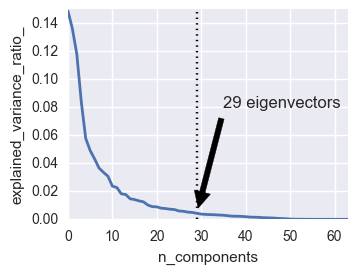

In [134]:
# Your code goes here
pca = PCA(n_components = digits.data.shape[1])
pca.fit(digits_data)

def return_index():
    count = 0.0
    for i in range(64):
        if count > 0.95:
            return i
        else:
            count += pca.explained_variance_ratio_[i]

nine_five = return_index()
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.vlines(nine_five,0,0.15,colors='k',linestyles='dotted')
plt.annotate('{} eigenvectors'.format(nine_five), xy=(nine_five, pca.explained_variance_ratio_[nine_five]), xytext=(35, 0.08),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

*Your answer goes here*  
The graph reach 95% of the variance at 29 components, this means 29 eigenvetors can represent to 95% of the data, so as to the other 35 features, they are not that important.

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

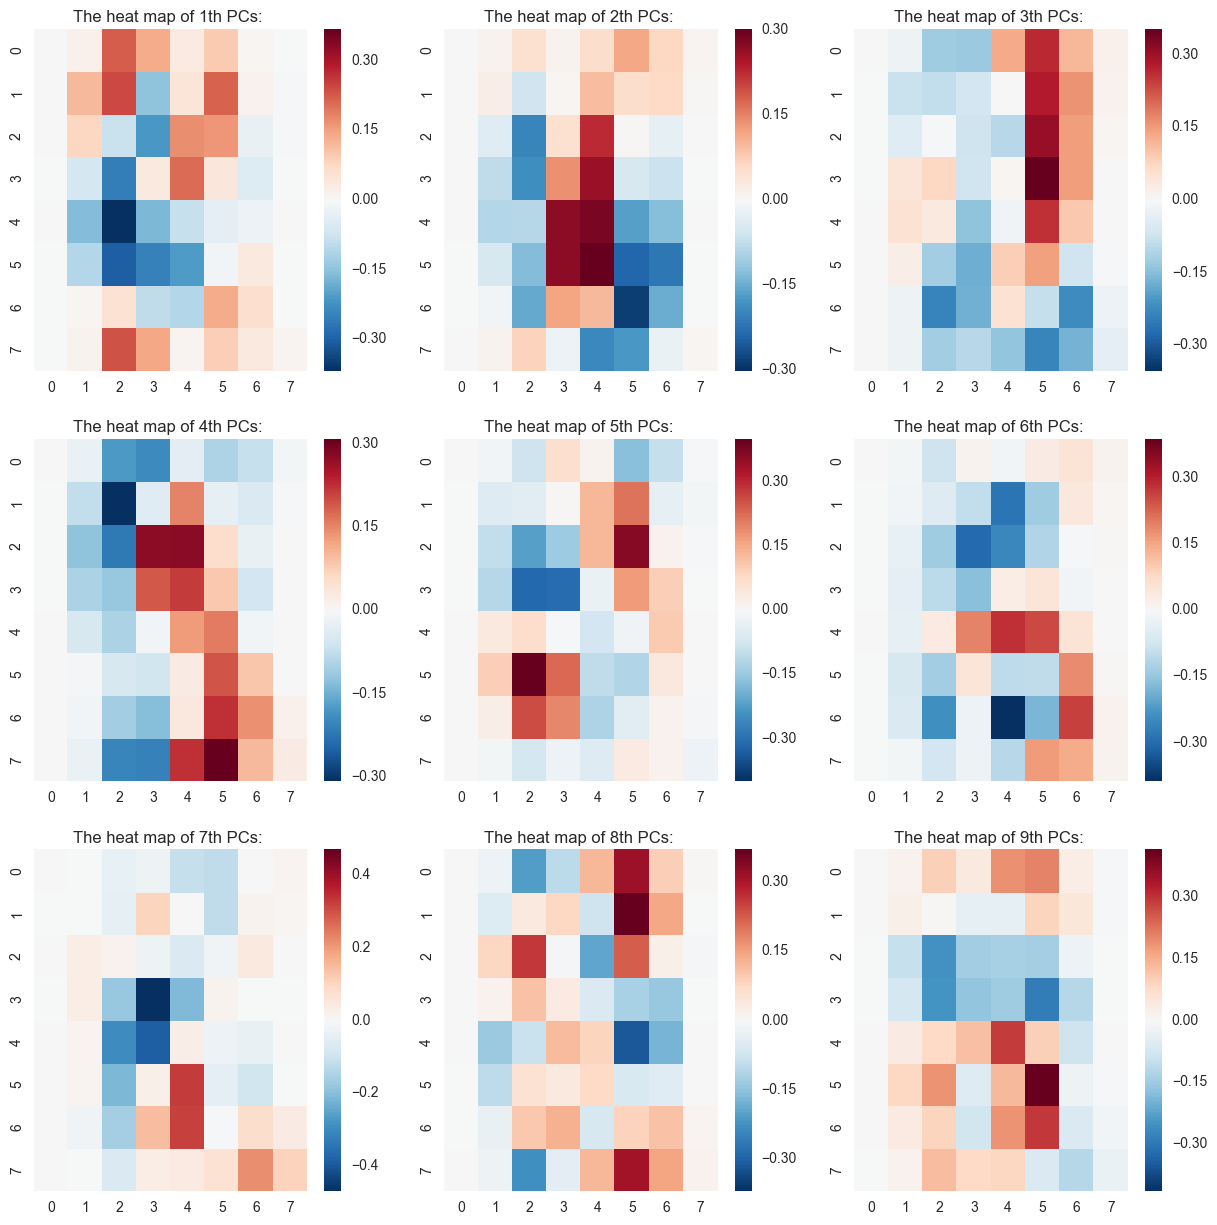

In [105]:
# Your code goes here
plt.figure()
plt.subplots(3,3,figsize = (15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    std_digits_target = pca.components_[i].reshape(8,8)
    sns.heatmap(std_digits_target)
    plt.title('The heat map of {}th PCs: '.format(i+1))
plt.show()

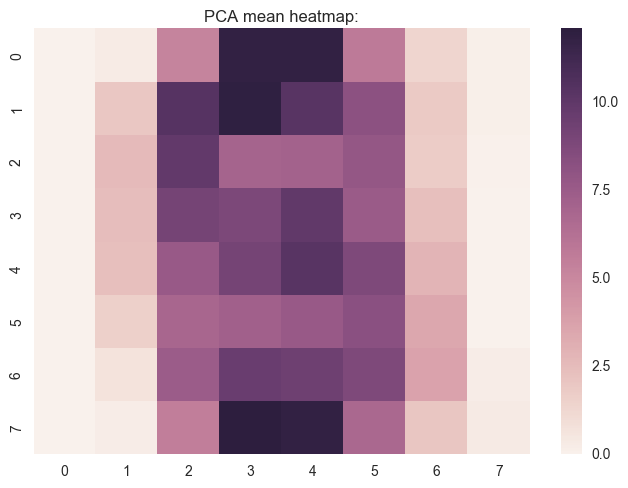

In [106]:
# PCA mean heatmap
sns.heatmap(pca.mean_.reshape(8,8))
plt.title("PCA mean heatmap:")
plt.show()

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

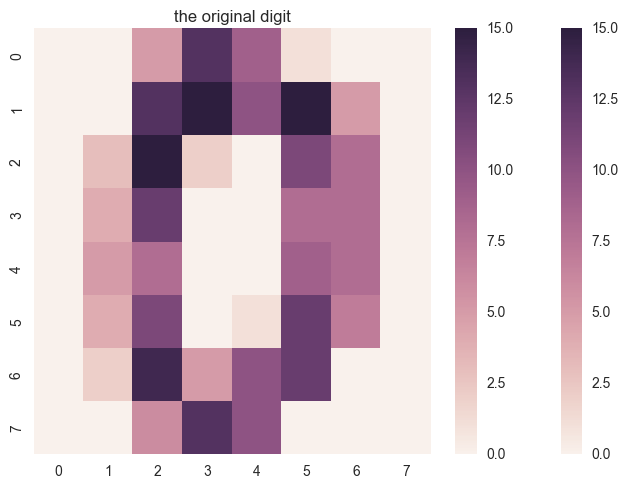

In [112]:
# the original digit
idx=0
coefficent = pca.transform(digits.data[0,:].reshape(1, -1)).flatten()
sns.heatmap(digits.data[0,:].reshape(8,8))
plt.title('the original digit')
plt.show()

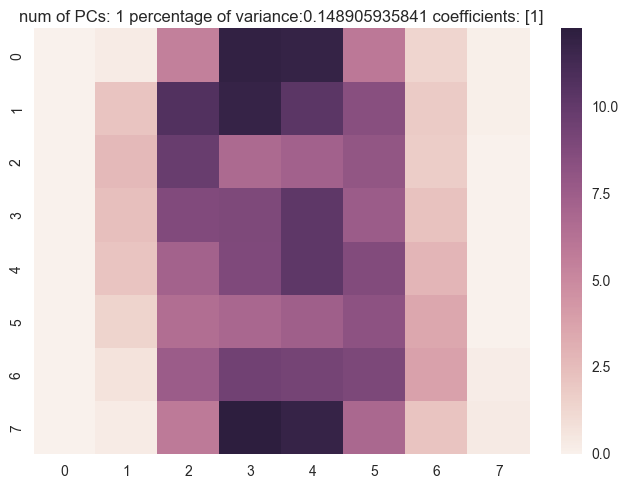

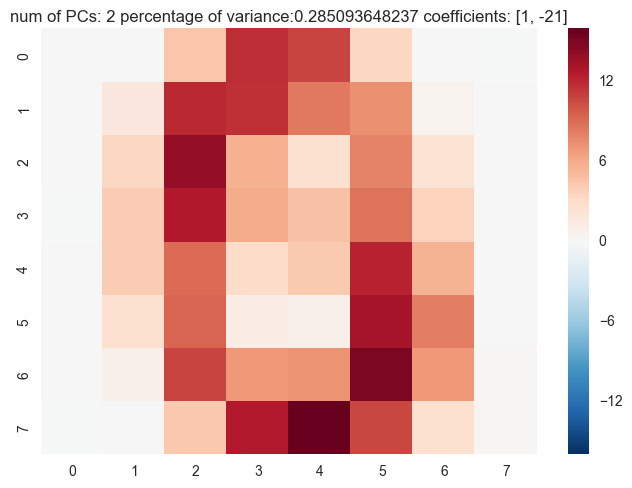

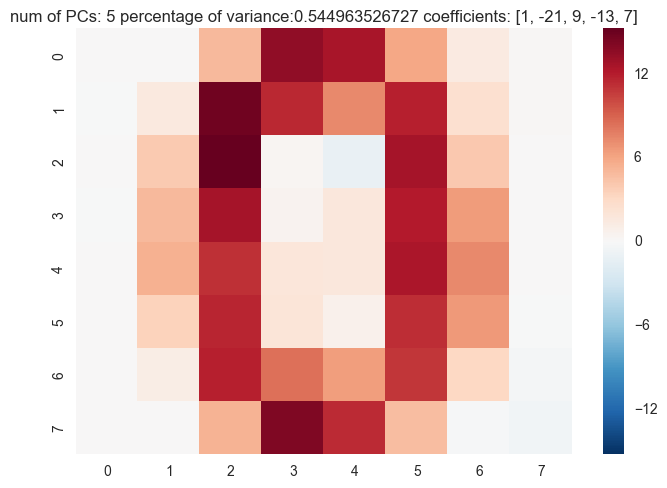

In [136]:
def calculate_digit(pca,pcs_num,coefficent):
    digits = np.zeros(pca.mean_.shape)
    biases = 0
    for i in range(pcs_num):
        biases += coefficent[i] * pca.components_[i]
    result = pca.mean_ + biases
    return result.reshape(8,8)

def calculate_percentage(pca, pcs_num):
    result = 0.0
    for i in range(pcs_num):
        result += pca.explained_variance_ratio_[i]
    return result

def calculate_coefficient(pca, pcs_num):
    result = []
    for i in range(pcs_num):
        result.append(int(coefficent[i]))
    return result 

# The digits reconstructed using 1,2,5 principal components
pcs_num = [1,2,5]
for index, i in enumerate(pcs_num):
    plt.figure()
    sns.heatmap(calculate_digit(pca, i, coefficent))
    plt.title('num of PCs: {} percentage of variance:{} coefficients: {}'.format(
    i,calculate_percentage(pca,i),calculate_coefficient(pca, i)))
    plt.show()

*Your answer goes here*  
Yes, the more eigenvectors, the more realistic is the produced digit. As we can see, with 5 pricipal components, we can already esaily tell the digit.

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [137]:
# Your code goes here
clf_linear = SVC(kernel='linear',shrinking=False,random_state=1337)
scores = cross_val_score(clf_linear, digits.data, digits.target, cv=5)
print("SVC without PCA: {}".format(scores.mean()))

SVC without PCA: 0.949334872621


In [138]:
pca_64 = PCA(n_components = 64)
pca_data = pca_64.fit_transform(digits.data)
scores = cross_val_score(clf_linear, pca_data, digits.target, cv=5)
print("SVC with PCA: {}".format(scores.mean()))

SVC with PCA: 0.949334872621


In [139]:
gnb = GaussianNB()
scores = cross_val_score(gnb, digits.data, digits.target, cv=5)
print("GNB without PCA: {}".format(scores.mean()))

GNB without PCA: 0.806520755555


In [141]:
scores = cross_val_score(gnb, pca_data, digits.target, cv=5)
print("GNB with PCA: {}".format(scores.mean()))

GNB with PCA: 0.835248016383


*Your answer goes here*  
As is shown above, the accuracy of Gaussian Naive Bayes model improved while the accuracy of SVC keep the same with the PCA data.
